# True unit bias types

author: steeve.laquitaine@epfl.ch  
last modified: 17-07-2023  
status: OK  
regression: None  



### Setup

Create or activate env `npx_10m_384ch_unit_classes`

In [1]:
%load_ext autoreload
%autoreload 2
import os 
from matplotlib import pyplot as plt
import numpy as np
from collections import Counter
import pandas as pd
import seaborn as sns 
import spikeinterface as si

proj_path = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/sfn_2023/"
os.chdir(proj_path)

from src.nodes.postpro.cell_matching import get_SpikeInterface_matching_object, match_sorted_to_true_neuropixels_2023_02_19
from src.nodes.utils import get_config
from src.nodes.postpro.feateng import (add_firing_rates)
from src.nodes.postpro import spike_stats


# SET PARAMETERS (npx384, 40KHz)
EXPERIMENT = "silico_neuropixels"
SIMULATION_DATE = "2023_10_18"
data_conf, param_conf = get_config(EXPERIMENT, SIMULATION_DATE).values()
KS3_SORTING_PATH = data_conf["sorting"]["sorters"]["kilosort3"]["output"]
GT_SORTING_PATH = data_conf["sorting"]["simulation"]["ground_truth"]["output"]
RECORDING_PATH = data_conf["recording"]["output"]
LOW_RATE_CEILING = 0.2  # max firing rate where negative proba change is observed in "bias plot" (sparse units)
DET_THRESH = 0.8
CHANCE_THRESH = 0.1

2023-10-27 15:04:52,113 - root - utils.py - get_config - INFO - Reading experiment config.
2023-10-27 15:04:52,127 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Get sorted x true matching score matrix

MatchingObject.agreement_scores rows (true units) and cols (sorted units)

In [2]:
# takes 10 min

# get true/sorted matching object
MatchingObject = get_SpikeInterface_matching_object(GT_SORTING_PATH, KS3_SORTING_PATH)

In [1]:
# import pickle
# with open('MatchingObject.pickle', 'wb') as handle:
#     pickle.dump(MatchingObject, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('MatchingObject.pickle', 'rb') as handle:
#     MatchingObject = pickle.load(handle)

We sort each row in descending order. The columns are not labelled as the raw ground truth anymore but become labelled as best match ground truth to the worst match.

In [6]:
# get sorted x true units' agreement scores
overmerging_matx = MatchingObject.agreement_scores.T

# sort each row such that the row with the highest score be first, while column order stays unchanged
argmax = overmerging_matx.T.idxmax().to_frame()
max = overmerging_matx.T.max()
descending_ix = np.argsort(max)[::-1]
overmerging_matx_2 = overmerging_matx.iloc[descending_ix]

# repeat for columns, row order stays auntouched
argmax = overmerging_matx_2.idxmax().to_frame()
max = overmerging_matx_2.max()
descending_ix = np.argsort(max)[::-1]
overmerging_matx_2 = overmerging_matx_2.iloc[:, descending_ix]

## Plot all true unit biases

We define biases types to characterize what happens to the true units (not with respect to sorted unit). This allows the proportion of all biases to sum to 100% over true units.

Based on our definitions:

* Possible biases types are:  
    * well detected
    * well detected + correlated unit
    * poorly detected    
    * oversplit
    * overmerged (include overmerged + poorly detected because this combination is always due to overmerging)   
    * overmerged + oversplit
    * overmerged + well detected + correlated unit
    * below chance    
    * missed
* Impossible biases types are:
    * poorly detected + oversplit (impossible because poorly detected requires matching at max a single sorted unit above chance, while oversplit requires matching at least two units)


To detect overmerged units and combinations

* need to look from perspective of sorted units
* A true unit is overmerged (with other true units) if it has at least one sorted units with a score between detection and chance that also has a score between detection and chance with another true unit.
* a poorly sorted units (accuracy between 0.1 and 0.8) can thus be overmerged (it fuse together half the spike trains of two true units). In that case it is classified as overmerged.

In [10]:
def classify_true_unit_biases(overmerging_matx_2, det_thresh, chance):

    # create masks
    mask_above_det = overmerging_matx_2 >= det_thresh
    mask_below_chance = overmerging_matx_2 <= chance
    mask_in_between = np.logical_and(
        overmerging_matx_2 < det_thresh, overmerging_matx_2 > chance
    )
    mask_entirely_missed = overmerging_matx_2 == 0

    # implement tree to classify ground truths
    # find ground truth (cols) with one mask_above_det=True and other mask_below_chance = True

    gt_classes = []
    gt_oversplitted = []
    for gt_i in range(overmerging_matx_2.shape[1]):

        # check if that ground truth has a single sorted unit above detection threshold
        if any(mask_above_det.iloc[:, gt_i]):

            # get this ground truth detection stata
            is_detected = mask_above_det.iloc[:, gt_i]
            detected_loc = np.where(is_detected)[0]
            detected_ix = is_detected.index[detected_loc]

            # get other cells
            other_cells_ix = is_detected.drop(index=detected_ix).index

            # get this ground truth below chance stata
            is_below_chance = mask_below_chance.iloc[:, gt_i]

            # check if all other sorted units are below chance
            if all(is_below_chance.loc[other_cells_ix]):
                gt_classes.append("well_detected")
            # if another unit is above chance bias is: well detected + correlated unit
            else:
                gt_classes.append("well_detected_plus_correlated_units")

        # case where ground truth matches only one sorted unit
        # with a score b/w detection and chance and
        # other units below chance
        # no score are above detection
        elif (sum(mask_in_between.iloc[:, gt_i]) == 1) and (
            any(mask_above_det.iloc[:, gt_i]) == False
        ):
            gt_classes.append("poorly_detected")

        # case a true unit is associated is a sorted unit with score
        # between detection and chance that is associated with other
        # true units with scores between detection and chances
        elif sum(mask_in_between.iloc[:, gt_i]) > 1:
            gt_classes.append("oversplit")

        # check that all sorted units have scores below
        # chance
        elif all(mask_below_chance.iloc[:, gt_i]):
            if all(mask_entirely_missed.iloc[:, gt_i]):
                gt_classes.append("missed")
            else:
                gt_classes.append("below_chance")

    # Detect overmerged units and combinations -------------

    # if one of its sorted units with score between
    # detection and chance has also a score between
    # detection and chance with another true unit
    # the true unit is overmerged (with another true unit)
    true_units_loc = np.where(mask_in_between.sum(axis=0) >= 1)[0]
    true_units = mask_in_between.columns[true_units_loc]
    gt_overmerged = dict()

    for gt_i in range(len(true_units_loc)):
        target_true_units_mx = mask_in_between.iloc[:, true_units_loc]
        sorted_u = np.where(target_true_units_mx.iloc[:, gt_i])[0]

        # check overmerged (that sorted unit merges other true units)
        if any(mask_in_between.iloc[sorted_u, :].sum(axis=1) > 1):
            overmerged_bool = mask_in_between.iloc[sorted_u, :].sum(axis=1) > 1
            overmerging_sorted = overmerged_bool.index[
                np.where(overmerged_bool)[0]
            ].to_list()
            gt_overmerged[true_units[gt_i]] = overmerging_sorted

    # count overmerged
    n_overmerged = len(gt_overmerged)

    # what other biases do overmerged units have?
    all_true_units = overmerging_matx_2.columns
    gt_classes_df = pd.DataFrame(data=gt_classes, index=all_true_units.to_list())
    print(
        "combination of biases:", np.unique(gt_classes_df.loc[gt_overmerged.keys(), :])
    )

    # label combination of biases
    gt_classes_df.loc[gt_overmerged.keys(), :] = gt_classes_df.loc[
        gt_overmerged.keys(), :
    ].apply(lambda x: x + " + overmerged")

    # poorly detected + overmerged units are poorly detected because overmerged so simply overmerged
    gt_classes_df[gt_classes_df == "poorly_detected + overmerged"] = "overmerged"
    print("detected biases:")
    display(gt_classes_df)
    return gt_classes_df


def plot_bias_type_hist(ax, gt_classes_df):

    # format dataframe to plot
    bias_types = [
        "well_detected",
        "well_detected_plus_correlated_units",
        "well_detected_plus_correlated_units + overmerged",
        "poorly_detected",
        "overmerged",
        "oversplit",
        "oversplit + overmerged",
        "below_chance",
        "missed",
    ]
    count_by_class = dict(Counter(gt_classes_df.values.squeeze().tolist()))

    # fill up count per bias
    for key_k in bias_types:
        try:
            count_by_class[key_k]
        except:
            count_by_class[key_k] = 0

    # create table
    data_df = pd.DataFrame(
        {"cell_count": list(count_by_class.values())}, index=bias_types
    )

    # plot

    # set combination colors
    oversplit_plus_overmerged = np.array([[0.6, 0.9, 0.6], [0, 0.7, 1]]).mean(axis=0)
    well_detected_plus_correlated_units_plus_overmerged = np.array(
        [[1, 0, 0], [0, 0.7, 1]]
    ).mean(axis=0)

    # set plot legend
    colors = [
        [0.7, 0.1, 0.1],  # "well_detected" (strong red)
        [1, 0, 0],  # "well_detected_plus_correlated_units" (red)
        well_detected_plus_correlated_units_plus_overmerged,
        [1, 0.85, 0.85],  # "poorly_detected" (pink)
        [0, 0.7, 1],  # "overmerged" (green)
        [0.6, 0.9, 0.6],  # "oversplit" (blue)
        oversplit_plus_overmerged,
        [0.95, 0.95, 0.95],  # "below chance"
        "k",  # "missed"
    ]

    # plot
    ax = (data_df).T.plot.barh(
        ax=axis,
        stacked=True,
        color=colors,
        width=0.2,
        edgecolor=[0.5, 0.5, 0.5],
        linewidth=0.2,
    )

    # set axis legend
    ax.spines[["left", "right", "top", "bottom"]].set_visible(False)
    x_axis = ax.axes.get_xaxis()
    x_axis.set_visible(True)
    y_axis = ax.axes.get_yaxis()
    y_axis.set_visible(False)
    x_axis = ax.axes.get_xaxis()
    x_axis.set_visible(False)
    ax.set_xlabel("true units (count)", fontsize=9)

    ax.legend(
        ncol=2,
        bbox_to_anchor=(0.1, 0.7),
        frameon=False,
        fontsize=9,
        handletextpad=0.6,
    )
    plt.tight_layout()

    # plt.savefig("figures/all_unit_accuracy_classes.pdf")

    # check total true units
    print("total true units (count):", data_df.sum().values[0])

    # count bias types
    display(data_df)

combination of biases: ['oversplit' 'poorly_detected' 'well_detected_plus_correlated_units']
detected biases:


,0
236454,well_detected_plus_correlated_units + overmerged
2148124,well_detected_plus_correlated_units + overmerged
3514704,well_detected_plus_correlated_units
891776,well_detected
1981516,well_detected_plus_correlated_units
...,...
3523081,below_chance
2227245,below_chance
4204246,below_chance
2258520,missed


total true units (count): 1310


,cell_count
well_detected,46
well_detected_plus_correlated_units,50
well_detected_plus_correlated_units + overmerged,44
poorly_detected,176
overmerged,142
oversplit,87
oversplit + overmerged,52
below_chance,711
missed,2


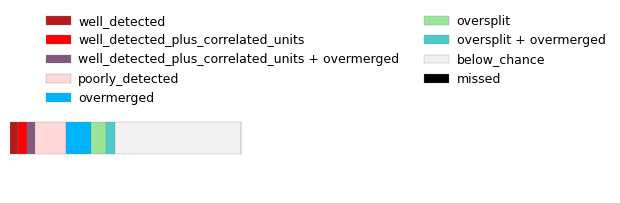

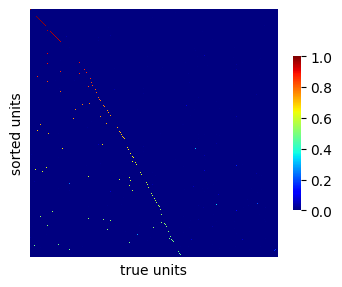

In [12]:
# classify unit biases
gt_classes_df = classify_true_unit_biases(overmerging_matx_2, DET_THRESH, CHANCE_THRESH)

# plot bias type histogram
# set figure
fig, axis = plt.subplots(1, 1, figsize=(10, 2))

plot_bias_type_hist(axis, gt_classes_df)

plt.savefig("figures/3_bias/pdf/bias_histo.pdf")
plt.savefig("figures/3_bias/svg/bias_histo.svg")

# plot agreement matrix
mx_to_plot = overmerging_matx_2.iloc[:500, :500].values
fig, axis = plt.subplots(figsize=(4, 4))
ax = sns.heatmap(
    mx_to_plot,
    cmap="jet",
    cbar_kws={"shrink": 0.5},
    yticklabels=False,
    xticklabels=False,
)
plt.xlabel("true units")
plt.ylabel("sorted units")
ax.set_aspect("equal")

plt.savefig("figures/3_bias/pdf/agreement_heatmap.pdf")
plt.savefig("figures/3_bias/svg/agreement_heatmap.svg")

## Plot sparse unit biases

In [1]:
# get sparse true units (below 0.2Hz)
# - get true firing rates
Recording = si.load_extractor(RECORDING_PATH)
SortingTrue = si.load_extractor(GT_SORTING_PATH)
true_rate = spike_stats.get_firing_rates(SortingTrue, Recording)
sparse_true_units = true_rate[true_rate["firing rate"] < LOW_RATE_CEILING][
    "cells"
].tolist()

# get each sparse unit's bias type
sparse_gt_classes_df = gt_classes_df.loc[sparse_true_units, :]

# plot
fig, axis = plt.subplots(figsize=(4, 4))
plot_bias_type_hist(ax, sparse_gt_classes_df)

NameError: name 'si' is not defined

## Plot active unit biases

total true units (count): 405


,cell_count
well_detected,42
well_detected_plus_correlated_units,47
poorly_detected,72
oversplit,87
overmerged,50
oversplit + overmerged,36
well_detected_plus_correlated_units + overmerged,6
below_chance,65
missed,0


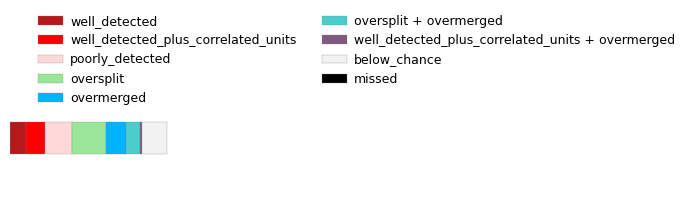

In [ ]:
# get active true units (above 0.2Hz)
active_true_units = true_rate[true_rate["firing rate"] >= LOW_RATE_CEILING][
    "cells"
].tolist()

# get each sparse unit's bias type
active_gt_classes_df = gt_classes_df.loc[active_true_units, :]

# plot
plot_bias_type_hist(ax, active_gt_classes_df)